In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Set

In [2]:
def filter_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter by
    - Require IVF_before_hr_24_no_L_cutoff >= 0.25 (i.e., 250 ml of IVF in first 24 hrs)
    - Exclude isolated head injuries (i.e., Head AIS >= 3 and all other AIS <= 1)
    :param df: compiled patient dataframe
    :return: filtered patient dataframe
    """
    max_ais_col_name = 'MaxNonHeadAIS'
    df[max_ais_col_name] = df[['MaxHeadAIS', 'MaxChestAIS', 'MaxAbdAIS', 'MaxSpineAIS', 'MaxLEAIS', 'MaxUEAIS', 'MaxFaceAIS', 'MaxNeckAIS']].max(axis=1)
    mask = (((df['IVF_before_hr_24_no_L_cutoff'] > 0.25) | np.isclose(df['IVF_before_hr_24_no_L_cutoff'], 0.25))
            & ((df['MaxHeadAIS'] < 3) | (df[max_ais_col_name] > 1))
            & (df['TraumaType'].str.strip().str.lower().isin({'b', 'p'})))
    filtered_data = df[mask]
    df.drop(columns=[max_ais_col_name], inplace=True)
    return filtered_data

def load_patient_cohort_ids() -> Set[int]:
    # load 2012-2015 patient cohort ids
    compiled_patient_data_2012_2015 = pd.read_csv('<path_to_dataset>/2012-2015_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')
    compiled_patient_data_2012_2015 = filter_data(compiled_patient_data_2012_2015)['StudyID']
    # load 2016-2019 patient cohort ids
    compiled_patient_data_2016_2019 = pd.read_csv('<path_to_dataset>/2016-2019_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')
    compiled_patient_data_2016_2019['StudyID'] = compiled_patient_data_2016_2019['StudyID'].astype(int)
    compiled_patient_data_2016_2019 = filter_data(compiled_patient_data_2016_2019)['StudyID']
    # combine patient cohort ids
    study_ids = set(compiled_patient_data_2012_2015.tolist()).union(set(compiled_patient_data_2016_2019.tolist()))
    print(f'Number of patient cohort ids: {len(study_ids)} (2012-2015: {len(compiled_patient_data_2012_2015)}, 2016-2019: {len(compiled_patient_data_2016_2019)})')
    return study_ids

# IVF Data Investigation

In [3]:
ivf_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_IVF_bolus_and_hourly.csv')
ivf_2012_2015_data.head()

,StudyID,ADMITDATE,DAY,FLUID,EventEndDtTm,ROUTE,Volume,UNIT
0,19334,5/14/13 0:00,4,Sodium Chloride 0.9%,5/17/13 7:59,IV Infusion,75.0,mL
1,19334,5/14/13 0:00,4,Sodium Chloride 0.9%,5/17/13 8:59,IV Infusion,75.0,mL
2,19334,5/14/13 0:00,4,Sodium Chloride 0.9%,5/17/13 9:59,IV Infusion,75.0,mL
3,19334,5/14/13 0:00,4,Sodium Chloride 0.9%,5/17/13 10:59,IV Infusion,75.0,mL
4,19334,5/14/13 0:00,4,Sodium Chloride 0.9%,5/17/13 11:59,IV Infusion,75.0,mL


In [4]:
ivf_2012_2015_data['ROUTE'].value_counts()

ROUTE
IV Infusion     586277
IVPB             78272
IV Push          28167
IV               12998
Hemodialysis       242
MISC                64
CRRT                 4
Name: count, dtype: int64

In [5]:
ivf_2012_2015_data['ROUTE'].isna().sum()

71587

In [6]:
ivf_2012_2015_data['ADMITDATE'] = pd.to_datetime(ivf_2012_2015_data['ADMITDATE'])
(ivf_2012_2015_data.loc[ivf_2012_2015_data['ROUTE'].isna(), 'ADMITDATE'].dt.year <= 2013).sum()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_33855/1190029902.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ivf_2012_2015_data['ADMITDATE'] = pd.to_datetime(ivf_2012_2015_data['ADMITDATE'])


45758

In [7]:
ivf_2012_2015_data['StudyID'].nunique()

7340

In [8]:
ivf_2012_2015_data.dtypes

StudyID                  int64
ADMITDATE       datetime64[ns]
DAY                      int64
FLUID                   object
EventEndDtTm            object
ROUTE                   object
Volume                 float64
UNIT                    object
dtype: object

In [9]:
filter_columns = ['StudyID', 'ADMITDATE', 'FLUID', 'EventEndDtTm', 'ROUTE', 'Volume', 'UNIT']
rename_columns = {'ADMITDATE': 'AdmitDtTm', 'FLUID': 'Fluid', 'ROUTE': 'Route', 'UNIT': 'Unit'}
filtered_ivf_data_2012_2015 = ivf_2012_2015_data[filter_columns]
filtered_ivf_data_2012_2015 = filtered_ivf_data_2012_2015.rename(columns=rename_columns)
filtered_ivf_data_2012_2015.head()

,StudyID,AdmitDtTm,Fluid,EventEndDtTm,Route,Volume,Unit
0,19334,2013-05-14,Sodium Chloride 0.9%,5/17/13 7:59,IV Infusion,75.0,mL
1,19334,2013-05-14,Sodium Chloride 0.9%,5/17/13 8:59,IV Infusion,75.0,mL
2,19334,2013-05-14,Sodium Chloride 0.9%,5/17/13 9:59,IV Infusion,75.0,mL
3,19334,2013-05-14,Sodium Chloride 0.9%,5/17/13 10:59,IV Infusion,75.0,mL
4,19334,2013-05-14,Sodium Chloride 0.9%,5/17/13 11:59,IV Infusion,75.0,mL


In [10]:
#ivf_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_IVF_ICU_no_L_required.csv', index_col=0)
ivf_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_IVF_all.csv')
#ivf_2016_2019_data['StudyID'] = ivf_2016_2019_data['StudyID'].astype(int)
ivf_2016_2019_data.head()

,StudyID,AdmitDate,EVENT_CD_DESCR,EventEndDtTm,Volume,OE_FIELD_DISPLAY_VALUE,RESULT_UNITS_CD_DESCR,Unnamed: 3
0,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 2:59 PM,52.0000,IV Infusion,mL,NaN
1,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 3:59 PM,52.0000,IV Infusion,mL,NaN
2,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 12:59 PM,52.0000,IV Infusion,mL,NaN
3,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 10:59 AM,43.3333,IV Infusion,mL,NaN
4,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 11:59 AM,52.0000,IV Infusion,mL,NaN


In [11]:
ivf_2016_2019_data['OE_FIELD_DISPLAY_VALUE'].value_counts()

OE_FIELD_DISPLAY_VALUE
IV Infusion            838934
IVPB                    79972
IV                      20678
Periph Nerve Cath        8232
PO                       8096
Epidural                 7304
Feeding Tube             4487
Nostril-Both             4358
Intra-arTERial           2850
G-Tube                   2138
Dialysis Infusion        1193
Irrigation               1050
Paravertebral Cath        852
NG-Tube                   482
Nebulized Inh             402
Rectal Irrigation         200
MISC                      159
IV Push                   148
Line Care                 103
IntraPLEural              100
Hemodialysis               53
Intranasal                 45
MISC Infusion              20
J-Tube                     20
CRRT                       16
IntraTHECAL                15
Urethral                    9
Pheresis Infusion           8
Nostril-Left                3
IntraPERitoneal             3
GI Tract                    2
I.V. Push (non-std)         1
Subcutaneous     

In [12]:
ivf_2016_2019_data['OE_FIELD_DISPLAY_VALUE'].isna().sum()

229

In [13]:
ivf_2016_2019_data['StudyID'].nunique()

8415

In [14]:
ivf_2016_2019_data.dtypes

StudyID                     int64
AdmitDate                  object
EVENT_CD_DESCR             object
EventEndDtTm               object
Volume                    float64
OE_FIELD_DISPLAY_VALUE     object
RESULT_UNITS_CD_DESCR      object
Unnamed: 3                float64
dtype: object

In [15]:
filter_columns = ['StudyID', 'AdmitDate', 'EVENT_CD_DESCR', 'EventEndDtTm', 'OE_FIELD_DISPLAY_VALUE', 'Volume', 'RESULT_UNITS_CD_DESCR']
rename_columns = {'AdmitDate': 'AdmitDtTm', 'EVENT_CD_DESCR': 'Fluid', 'OE_FIELD_DISPLAY_VALUE': 'Route', 'RESULT_UNITS_CD_DESCR': 'Unit'}
filtered_ivf_data_2016_2019 = ivf_2016_2019_data[filter_columns]
filtered_ivf_data_2016_2019 = filtered_ivf_data_2016_2019.rename(columns=rename_columns)
filtered_ivf_data_2016_2019.head()

,StudyID,AdmitDtTm,Fluid,EventEndDtTm,Route,Volume,Unit
0,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 2:59 PM,IV Infusion,52.0000,mL
1,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 3:59 PM,IV Infusion,52.0000,mL
2,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 12:59 PM,IV Infusion,52.0000,mL
3,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 10:59 AM,IV Infusion,43.3333,mL
4,1709,8/29/16,Dextrose 5% with 0.9% NaCl-KCl 20mEq/l,8/29/16 11:59 AM,IV Infusion,52.0000,mL


In [16]:
ivf_data = pd.concat([filtered_ivf_data_2012_2015, filtered_ivf_data_2016_2019], axis=0)
ivf_data.head()

,StudyID,AdmitDtTm,Fluid,EventEndDtTm,Route,Volume,Unit
0,19334,2013-05-14 00:00:00,Sodium Chloride 0.9%,5/17/13 7:59,IV Infusion,75.0,mL
1,19334,2013-05-14 00:00:00,Sodium Chloride 0.9%,5/17/13 8:59,IV Infusion,75.0,mL
2,19334,2013-05-14 00:00:00,Sodium Chloride 0.9%,5/17/13 9:59,IV Infusion,75.0,mL
3,19334,2013-05-14 00:00:00,Sodium Chloride 0.9%,5/17/13 10:59,IV Infusion,75.0,mL
4,19334,2013-05-14 00:00:00,Sodium Chloride 0.9%,5/17/13 11:59,IV Infusion,75.0,mL


In [17]:
ivf_data['StudyID'].nunique()

15755

In [18]:
assert ivf_data['StudyID'].nunique() == ivf_2012_2015_data['StudyID'].nunique() + ivf_2016_2019_data['StudyID'].nunique(), 'Study IDs duplicated across datasets'

In [19]:
cohort_study_ids = load_patient_cohort_ids()
ivf_data = ivf_data[ivf_data['StudyID'].isin(cohort_study_ids)]
ivf_data['StudyID'].nunique()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_33855/782841116.py:20: DtypeWarning: Columns (1,2,133) have mixed types. Specify dtype option on import or set low_memory=False.
  compiled_patient_data_2012_2015 = pd.read_csv('/Users/larry/Documents/UWT/Thesis Work/rec_sys/datasets/trauma_icu_resuscitation/2012-2015_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')


Number of patient cohort ids: 9354 (2012-2015: 4484, 2016-2019: 4870)


9354

# Unit Investigation

In [20]:
ivf_data['Unit'].isna().sum()

0

In [21]:
ivf_data['Unit'].value_counts()

Unit
mL             1197542
g                30800
mEq              13359
spray(s)          2802
application        114
each                10
L                    5
Name: count, dtype: int64

In [22]:
ivf_data[ivf_data['Unit'] == 'mEq']['Fluid'].value_counts()

Fluid
sodium chloride    13359
Name: count, dtype: int64

In [23]:
ivf_data[ivf_data['Unit'] == 'mEq']['Volume'].value_counts()

Volume
17.100000    828
25.650000    413
31.333333    342
8.550000     302
5.833131     191
            ... 
15.658413      1
5.519001       1
22.230000      1
0.138898       1
19.999995      1
Name: count, Length: 1054, dtype: int64

count    13359.000000
mean        14.031652
std         23.311895
min          0.050589
25%          5.833653
50%         10.416540
75%         18.023060
max        684.000000
Name: Volume, dtype: float64


<Axes: >

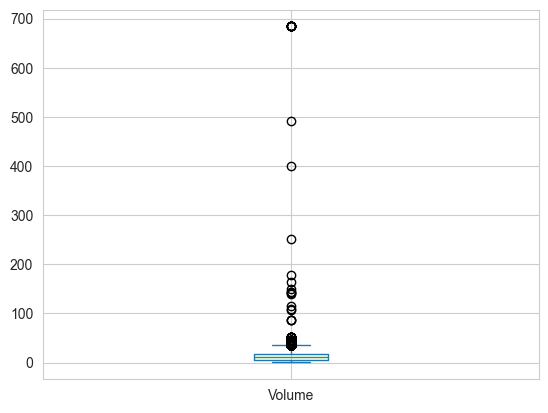

In [24]:
print(ivf_data[ivf_data['Unit'] == 'mEq']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'mEq']['Volume'].plot.box()

In [25]:
ivf_data[ivf_data['Unit'] == 'g']['Fluid'].value_counts()

Fluid
Dextrose 70% in Water    25895
sodium chloride           3671
Dextrose 20% in Water     1234
Name: count, dtype: int64

count    30800.000000
mean        14.677836
std         16.707407
min          0.195610
25%          9.375747
50%         14.583932
75%         17.707547
max       1921.061105
Name: Volume, dtype: float64


<Axes: >

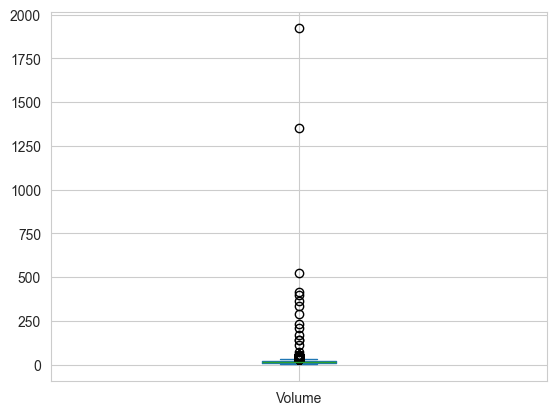

In [26]:
print(ivf_data[ivf_data['Unit'] == 'g']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'g']['Volume'].plot.box()

count    1.197542e+06
mean     1.589708e+03
std      1.655754e+06
min      8.000000e-05
25%      1.000000e+01
50%      2.916670e+01
75%      1.000000e+02
max      1.811924e+09
Name: Volume, dtype: float64


<Axes: >

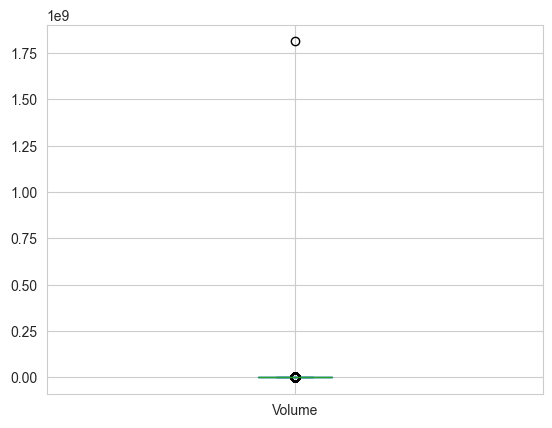

In [27]:
print(ivf_data[ivf_data['Unit'] == 'mL']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'mL']['Volume'].plot.box()

In [28]:
ivf_data[ivf_data['Unit'] == 'mL']['Fluid'].value_counts()

Fluid
Sodium Chloride 0.9%                        626792
Dextrose 5% in Water                        120547
Lactated Ringers Injection                  106121
Dextrose 5% in Lactated Ringers Injectio    105686
Dextrose 5% with 0.45% NaCl-KCl 20mEq/l      60034
sodium chloride                              54179
Dextrose 5% with 0.45% NaCl                  36236
Dextrose 5% with 0.9% NaCl                   27758
Dextrose 5% with 0.9% NaCl-KCl 20mEq/l       15249
Dextrose 70% in Water                        13664
Electrolyte Solution (Plasma-Lyte)            8897
Sodium Chloride 0.9% with KCL 20 mEq/l        6835
Dextrose 50% in Water                         5686
Sodium Chloride 0.45%                         3870
Dextrose 10% in Water                         3610
Sodium Chloride 3%                             879
Dextrose 5% with 0.45% NaCl-KCl 40mEq/l        617
Dextrose 5% with 0.2% NaCl                     433
Dextrose 20% in Water                          426
Sodium Chloride 2%       

In [29]:
ivf_data[ivf_data['Unit'] == 'spray(s)']['Fluid'].value_counts()

Fluid
sodium chloride nasal    2802
Name: count, dtype: int64

count    2802.000000
mean        1.864026
std         0.760783
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Volume, dtype: float64


<Axes: >

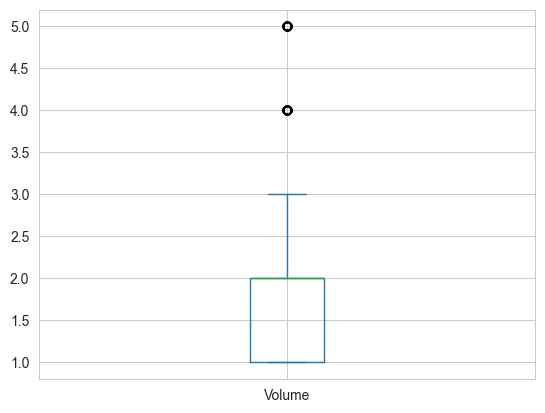

In [30]:
print(ivf_data[ivf_data['Unit'] == 'spray(s)']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'spray(s)']['Volume'].plot.box()

In [31]:
ivf_data[ivf_data['Unit'] == 'application']['Fluid'].value_counts()

Fluid
sodium chloride nasal         52
sodium chloride               43
Lactated Ringers Injection    19
Name: count, dtype: int64

count    114.000000
mean       4.912281
std       28.363806
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      250.000000
Name: Volume, dtype: float64


<Axes: >

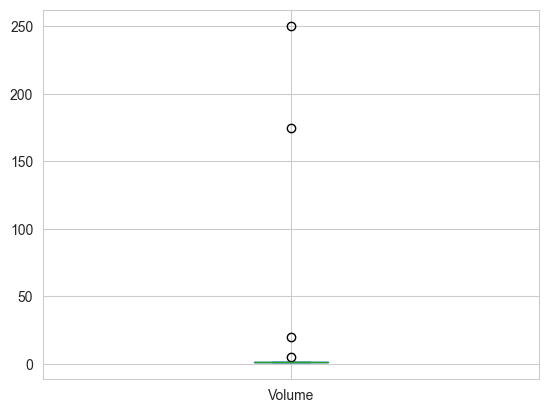

In [32]:
print(ivf_data[ivf_data['Unit'] == 'application']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'application']['Volume'].plot.box()

In [33]:
ivf_data[ivf_data['Unit'] == 'each']['Fluid'].value_counts()

Fluid
sodium chloride               7
Lactated Ringers Injection    3
Name: count, dtype: int64

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: Volume, dtype: float64


<Axes: >

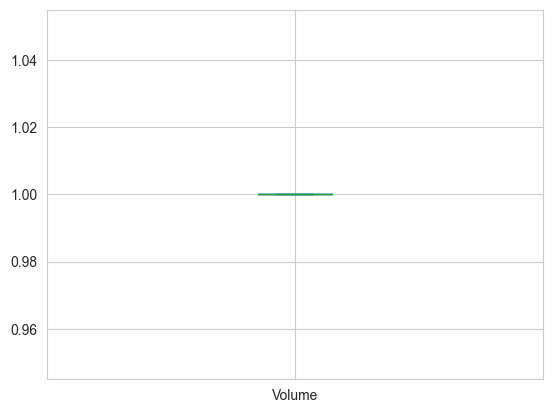

In [34]:
print(ivf_data[ivf_data['Unit'] == 'each']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'each']['Volume'].plot.box()

count    2926.000000
mean        1.979836
std         5.655579
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max       250.000000
Name: Volume, dtype: float64


<Axes: >

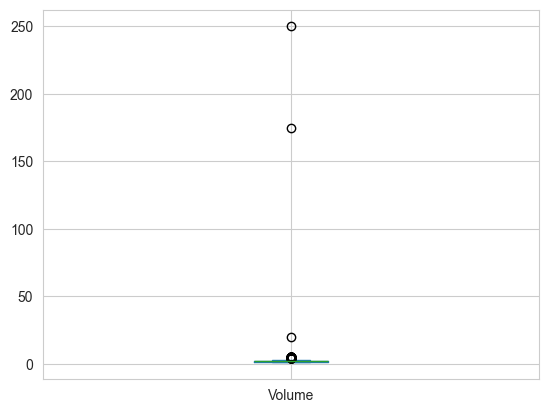

In [35]:
mask = (ivf_data['Unit'] == 'each') | (ivf_data['Unit'] == 'application') | (ivf_data['Unit'] == 'spray(s)')
print(ivf_data[mask]['Volume'].describe())
ivf_data[mask]['Volume'].plot.box()

In [36]:
ivf_data[ivf_data['Unit'] == 'L']['Fluid'].value_counts()

Fluid
Lactated Ringers Injection    3
Sodium Chloride 0.9%          2
Name: count, dtype: int64

In [37]:
ivf_data[ivf_data['Unit'] == 'L']['Volume'].value_counts()

Volume
1.0       2
4000.0    1
2.0       1
1.5       1
Name: count, dtype: int64

count       5.000000
mean      801.100000
std      1788.239511
min         1.000000
25%         1.000000
50%         1.500000
75%         2.000000
max      4000.000000
Name: Volume, dtype: float64


<Axes: >

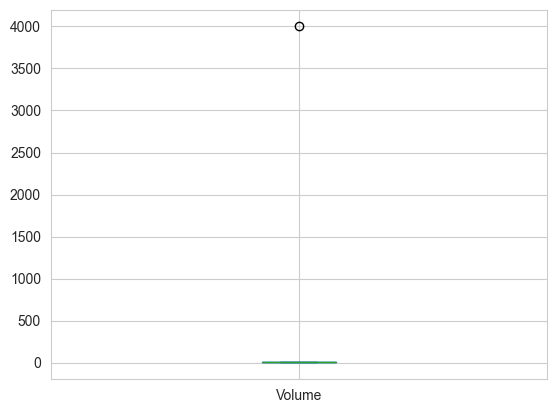

In [38]:
print(ivf_data[ivf_data['Unit'] == 'L']['Volume'].describe())
ivf_data[ivf_data['Unit'] == 'L']['Volume'].plot.box()

In [39]:
ivf_data['Unit'].isna().sum()

0

# Fluid Investigation

In [40]:
ivf_data['Fluid'].value_counts()

Fluid
Sodium Chloride 0.9%                        626794
Dextrose 5% in Water                        120547
Lactated Ringers Injection                  106146
Dextrose 5% in Lactated Ringers Injectio    105686
sodium chloride                              71259
Dextrose 5% with 0.45% NaCl-KCl 20mEq/l      60034
Dextrose 70% in Water                        39559
Dextrose 5% with 0.45% NaCl                  36236
Dextrose 5% with 0.9% NaCl                   27758
Dextrose 5% with 0.9% NaCl-KCl 20mEq/l       15249
Electrolyte Solution (Plasma-Lyte)            8897
Sodium Chloride 0.9% with KCL 20 mEq/l        6835
Dextrose 50% in Water                         5686
Sodium Chloride 0.45%                         3870
Dextrose 10% in Water                         3610
sodium chloride nasal                         2854
Dextrose 20% in Water                         1660
Sodium Chloride 3%                             879
Dextrose 5% with 0.45% NaCl-KCl 40mEq/l        617
Dextrose 5% with 0.2% NaC

# Correct Units

In [41]:
def correct_and_filter_ivf(df: pd.DataFrame):
    # drop units each, application, spray(s), mEq, and g
    df.drop(df[df['Unit'].isin({'each', 'application', 'spray(s)', 'mEq', 'g'})].index, inplace=True)
    # convert liters to ml
    # 4000 L is likely a mistake. It's probably 4000 ml. So update everything less than 1000 L
    df.loc[(df['Unit'] == 'L') & (df['Volume'] < 1000), 'Observation'] = df.loc[(df['Unit'] == 'L') & (df['Volume'] < 1000), 'Volume'] * 1000
    df.loc[df['Unit'] == 'L', 'Unit'] = 'mL'
    assert (df['Unit'] == 'mL').all(), df['Unit'].unique()
    # drop routes that are not IV, IV Infusion, IVPB, IV Push, I.V. Push (non-std), or NaN
    df.drop(df[~df['Route'].isin({'IV', 'IV Infusion', 'IVPB', 'IV Push', 'I.V. Push (non-std)', np.nan})].index, inplace=True)
    # drop missing data
    df.drop(df[df['Volume'].isna()].index, inplace=True)

In [42]:
correct_and_filter_ivf(ivf_data)
ivf_data['Unit'].value_counts()

Unit
mL    1147160
Name: count, dtype: int64

In [43]:
ivf_data['Volume'].describe()

count    1.147160e+06
mean     1.656419e+03
std      1.691722e+06
min      8.000000e-05
25%      1.000000e+01
50%      3.000000e+01
75%      1.000000e+02
max      1.811924e+09
Name: Volume, dtype: float64

<Axes: >

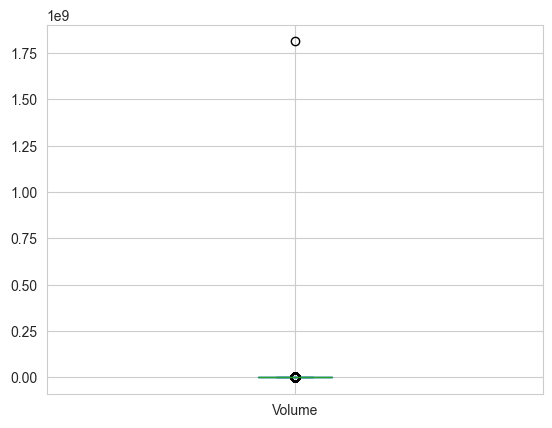

In [44]:
ivf_data['Volume'].plot.box()

<Axes: >

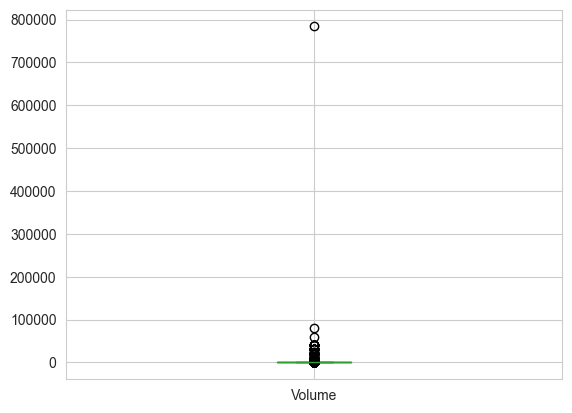

In [45]:
ivf_data.loc[ivf_data['Volume'] < 1e6, 'Volume'].plot.box()

# Vasopressor Data Investigation

In [72]:
vasopressor_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_Pressors.csv')
rename_columns = {'Dose': 'Volume'}
vasopressor_2012_2015_data = vasopressor_2012_2015_data.rename(columns=rename_columns)
vasopressor_2012_2015_data.head()

,StudyID,AdmitDate,Pressor,EventEndDtTm,Volume
0,16015,1/2/12,norepinephrine,1/2/12 3:59 PM,1.195
1,16015,1/2/12,norepinephrine,1/2/12 4:59 PM,0.290
2,16020,1/3/12,phenylephrine,1/3/12 10:59 PM,1.275
3,16020,1/3/12,vasopressin,1/3/12 10:59 PM,2.040
4,16020,1/3/12,phenylephrine,1/3/12 11:59 PM,1.500


In [73]:
vasopressor_2012_2015_data['StudyID'].nunique()

826

In [74]:
vasopressor_2012_2015_data.dtypes

StudyID           int64
AdmitDate        object
Pressor          object
EventEndDtTm     object
Volume          float64
dtype: object

In [75]:
vasopressor_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_Pressors.csv')
rename_columns = {'PressorDose': 'Volume'}
vasopressor_2016_2019_data = vasopressor_2016_2019_data.rename(columns=rename_columns)
vasopressor_2016_2019_data.head()

,StudyID,AdmitDate,Pressor,EventEndDtTm,Volume
0,3,1/1/16,norepinephrine,1/4/16 7:59,0.550144
1,3,1/1/16,norepinephrine,1/4/16 8:59,0.654400
2,3,1/1/16,norepinephrine,1/4/16 9:59,0.654400
3,3,1/1/16,norepinephrine,1/4/16 10:59,0.654400
4,3,1/1/16,norepinephrine,1/4/16 11:59,0.811760


In [76]:
vasopressor_2016_2019_data['StudyID'].nunique()

1538

In [77]:
vasopressor_2016_2019_data.dtypes

StudyID           int64
AdmitDate        object
Pressor          object
EventEndDtTm     object
Volume          float64
dtype: object

In [78]:
vasopressor_data = pd.concat([vasopressor_2012_2015_data, vasopressor_2016_2019_data], axis=0)
vasopressor_data.head()

,StudyID,AdmitDate,Pressor,EventEndDtTm,Volume
0,16015,1/2/12,norepinephrine,1/2/12 3:59 PM,1.195
1,16015,1/2/12,norepinephrine,1/2/12 4:59 PM,0.290
2,16020,1/3/12,phenylephrine,1/3/12 10:59 PM,1.275
3,16020,1/3/12,vasopressin,1/3/12 10:59 PM,2.040
4,16020,1/3/12,phenylephrine,1/3/12 11:59 PM,1.500


In [79]:
vasopressor_data['StudyID'].nunique()

2364

In [80]:
assert vasopressor_data['StudyID'].nunique() == vasopressor_2012_2015_data['StudyID'].nunique() + vasopressor_2016_2019_data['StudyID'].nunique(), 'Study IDs duplicated across datasets'

In [81]:
vasopressor_data = vasopressor_data[vasopressor_data['StudyID'].isin(cohort_study_ids)]
vasopressor_data['StudyID'].nunique()

1576

In [82]:
vasopressor_data['Pressor'].value_counts()

Pressor
norepinephrine    59637
vasopressin       17443
phenylephrine     13796
DOBUTamine         1943
DOPamine           1642
EPINEPHrine        1169
ePHEDrine           607
Name: count, dtype: int64

count    5.959300e+04
mean     1.946717e+03
std      4.750313e+05
min      1.410000e-04
25%      2.400000e-01
50%      4.774640e-01
75%      9.541840e-01
max      1.159631e+08
Name: Volume, dtype: float64


<Axes: >

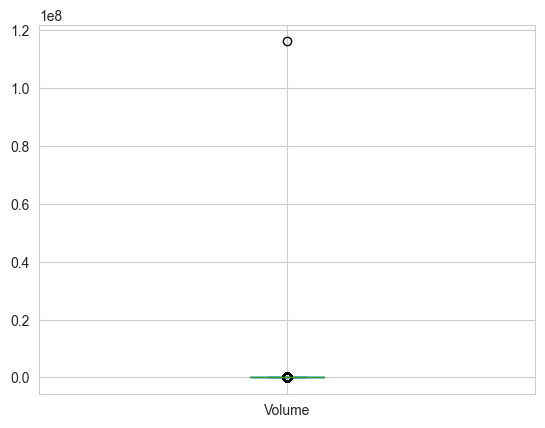

In [83]:
mask = vasopressor_data['Pressor'] == 'norepinephrine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    59592.000000
mean         0.799076
std          1.537265
min          0.000141
25%          0.240000
50%          0.477452
75%          0.954130
max        138.750080
Name: Volume, dtype: float64


<Axes: >

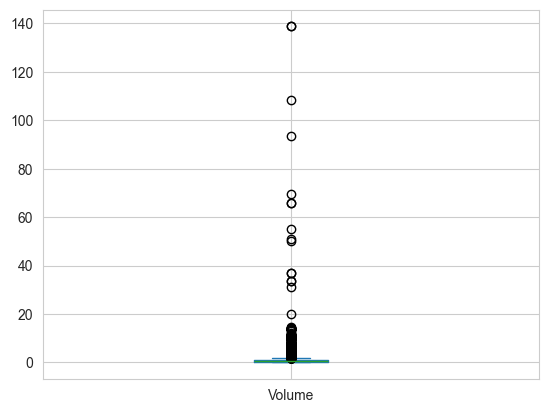

In [84]:
mask = (vasopressor_data['Pressor'] == 'norepinephrine') & (vasopressor_data['Volume'] < 5000000)
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    17441.000000
mean         2.468417
std          6.669204
min          0.001700
25%          2.400000
50%          2.400000
75%          2.400000
max        240.000000
Name: Volume, dtype: float64


<Axes: >

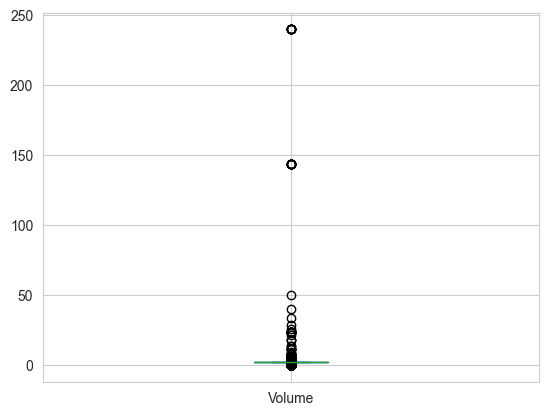

In [59]:
mask = vasopressor_data['Pressor'] == 'vasopressin'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    13781.000000
mean         3.674233
std         11.412655
min          0.000220
25%          1.060000
50%          2.385000
75%          4.483300
max       1000.000000
Name: Volume, dtype: float64


<Axes: >

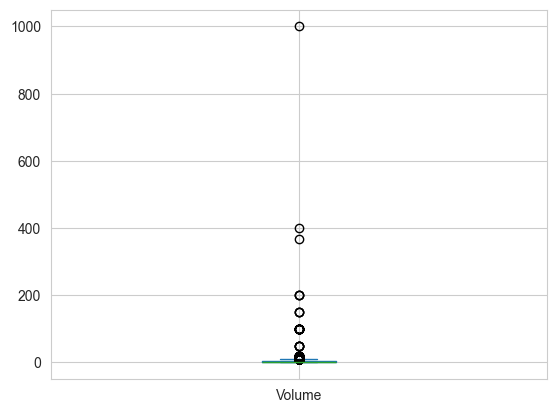

In [60]:
mask = vasopressor_data['Pressor'] == 'phenylephrine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    1943.000000
mean       18.893921
std        15.226076
min         0.120000
25%         8.760000
50%        15.360000
75%        24.320000
max       134.400000
Name: Volume, dtype: float64


<Axes: >

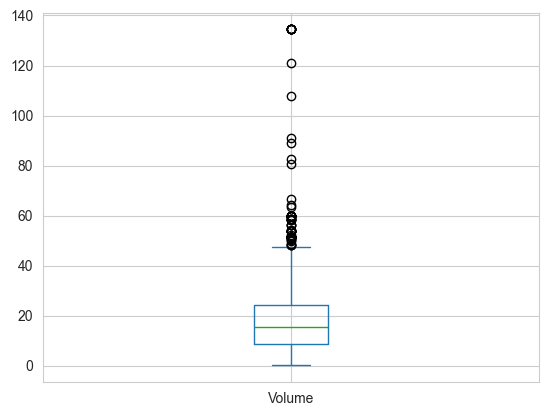

In [61]:
mask = vasopressor_data['Pressor'] == 'DOBUTamine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    1637.000000
mean       29.197077
std        24.022219
min         0.048000
25%        14.592000
50%        22.816000
75%        36.448000
max       256.128000
Name: Volume, dtype: float64


<Axes: >

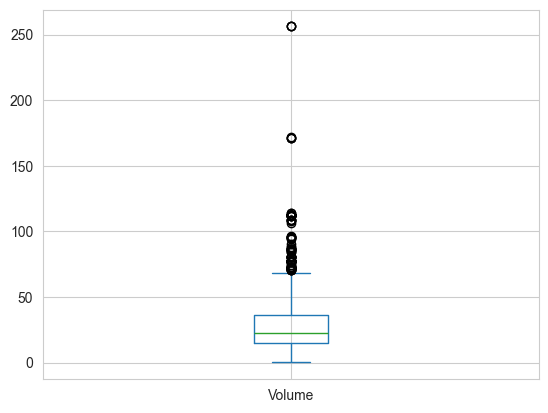

In [62]:
mask = vasopressor_data['Pressor'] == 'DOPamine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    1166.000000
mean        1.183675
std         1.448869
min         0.003850
25%         0.318000
50%         0.602500
75%         1.404000
max         7.296000
Name: Volume, dtype: float64


<Axes: >

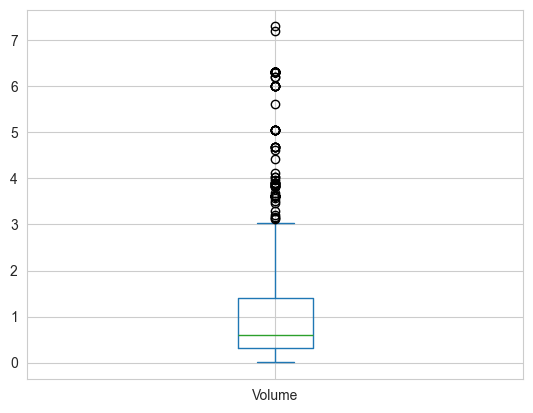

In [63]:
mask = vasopressor_data['Pressor'] == 'EPINEPHrine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    607.000000
mean      27.257002
std       10.135868
min        5.000000
25%       25.000000
50%       25.000000
75%       25.000000
max       75.000000
Name: Volume, dtype: float64


<Axes: >

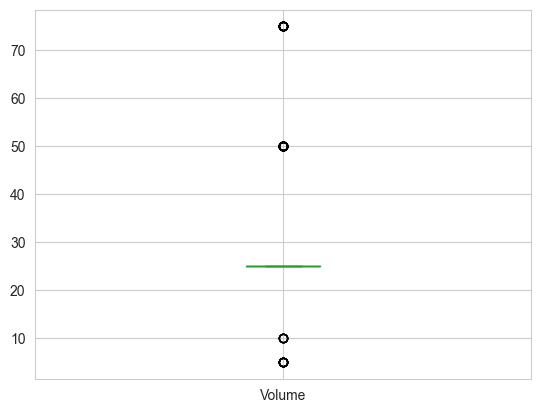

In [64]:
mask = vasopressor_data['Pressor'] == 'ePHEDrine'
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

In [87]:
norepinephrine_outlier_mask = vasopressor_data[(vasopressor_data['Pressor'] == 'norepinephrine') & (vasopressor_data['Volume'] >= 5000000)].index
vasopressor_data.drop(norepinephrine_outlier_mask, inplace=True)
# I think these outliers may have accidentally been recorded with an extra 0
vasopressin_outlier_mask = vasopressor_data[(vasopressor_data['Pressor'] == 'vasopressin') & (vasopressor_data['Volume'] > 100)].index
vasopressor_data.loc[vasopressin_outlier_mask, 'Volume'] = vasopressor_data.loc[vasopressin_outlier_mask, 'Volume'] / 10
phenylephrine_outlier_mask = vasopressor_data[(vasopressor_data['Pressor'] == 'phenylephrine') & (vasopressor_data['Volume'] > 200)].index
vasopressor_data.loc[phenylephrine_outlier_mask, 'Volume'] = vasopressor_data.loc[phenylephrine_outlier_mask, 'Volume'] / 10
DOBUTamine_outlier_mask = vasopressor_data[(vasopressor_data['Pressor'] == 'DOBUTamine') & (vasopressor_data['Volume'] > 100)].index
vasopressor_data.loc[DOBUTamine_outlier_mask, 'Volume'] = vasopressor_data.loc[DOBUTamine_outlier_mask, 'Volume'] / 10
DOPamine_outlier_mask = vasopressor_data[(vasopressor_data['Pressor'] == 'DOPamine') & (vasopressor_data['Volume'] > 150)].index
vasopressor_data.loc[DOPamine_outlier_mask, 'Volume'] = vasopressor_data.loc[DOPamine_outlier_mask, 'Volume'] / 10
# EPINEPHrine: no changes
# ePHEDrine: no changes
# drop missing data
vasopressor_data.drop(vasopressor_data[vasopressor_data['Volume'].isna()].index, inplace=True)

count    59567.000000
mean         0.798932
std          1.537457
min          0.000141
25%          0.240000
50%          0.477024
75%          0.953815
max        138.750080
Name: Volume, dtype: float64


<Axes: >

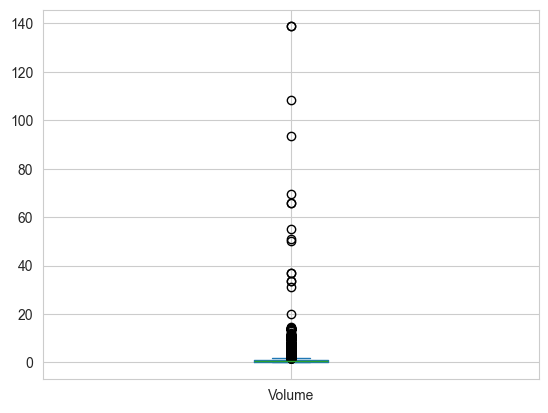

In [88]:
mask = (vasopressor_data['Pressor'] == 'norepinephrine')
print(vasopressor_data[mask]['Volume'].describe())
vasopressor_data[mask]['Volume'].plot.box()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Volume, dtype: float64


<Axes: >

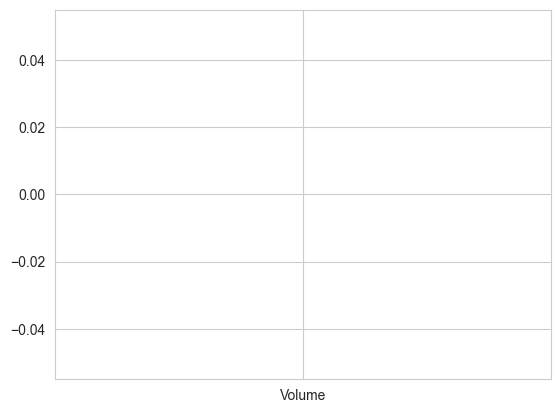

In [85]:
temp = vasopressor_data.drop((vasopressor_data.loc[vasopressor_data['Pressor'] == 'norepinephrine', 'Volume'] >= 5000000).index)
mask = (temp['Pressor'] == 'norepinephrine')
print(temp[mask]['Volume'].describe())
temp[mask]['Volume'].plot.box()